# Self-RAG

Self-RAG is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents and generations. 

In the [paper](https://arxiv.org/abs/2310.11511), a few decisions are made:

1. Should I retrieve from retriever, `R` -> 정보 검색을 해야 할지 먼저 결정한다. 

* Input: `x (question)` OR `x (question)`, `y (generation)`
* llm이 질문을 받았을 때, 추가로 정보를 검색할 필요가 있는지 판단하는 단계 
* Output: `yes, no, continue`

2. Are the retrieved passages `D` relevant to the question `x` -> 검색된 문서가 질문과 관련이 있는지 평가 

* * Input: 질문 x와 각 문서 조각 d(검색된 문서 D 중 하나의 청크)
* 검색된 문서 조각 `d`가 질문에 답하는데 유용한지 판단 
* Output: `relevant, irrelevant`

3. llm이 생성한 답변이 해당 문서 조각과 일치하는지 평가 (hallucinations, etc)  -

* Input: 질문 x, 문서 조각 d, 그로부터 생성된 답변 y 
* 생성된 답변 y가 해당 문서 조각 d에 의해 충분히 뒷받침되는지 검토, 생성된 답변이 문서와 일치하는지, 사실 왜곡이나 오류가 있는지 평가 
* Output: `{fully supported, partially supported, no support`

4. 생성된 답변이 질문에 유용한 응답인지 평가

* Input: 질문 x와 각 문서 조각으로 생성된 답변 y 
* 생성된 답변이 질문에 대해 유용한 응답인지 평가 
* Output: `{5, 4, 3, 2, 1}`클수록 유용함 

신뢰성을 높이기 위해 llm이 스스로의 답변을 지속적으로 검토하고 생성된 답변이 문서에서 파생된 정보에 기반하는지 평가함. 
질문에 대해 얼마나 유용한 답변인지 점수를 매겨 최종 응답을 개선한다. 

We will implement some of these ideas from scratch using [LangGraph](https://langchain-ai.github.io/langgraph/).

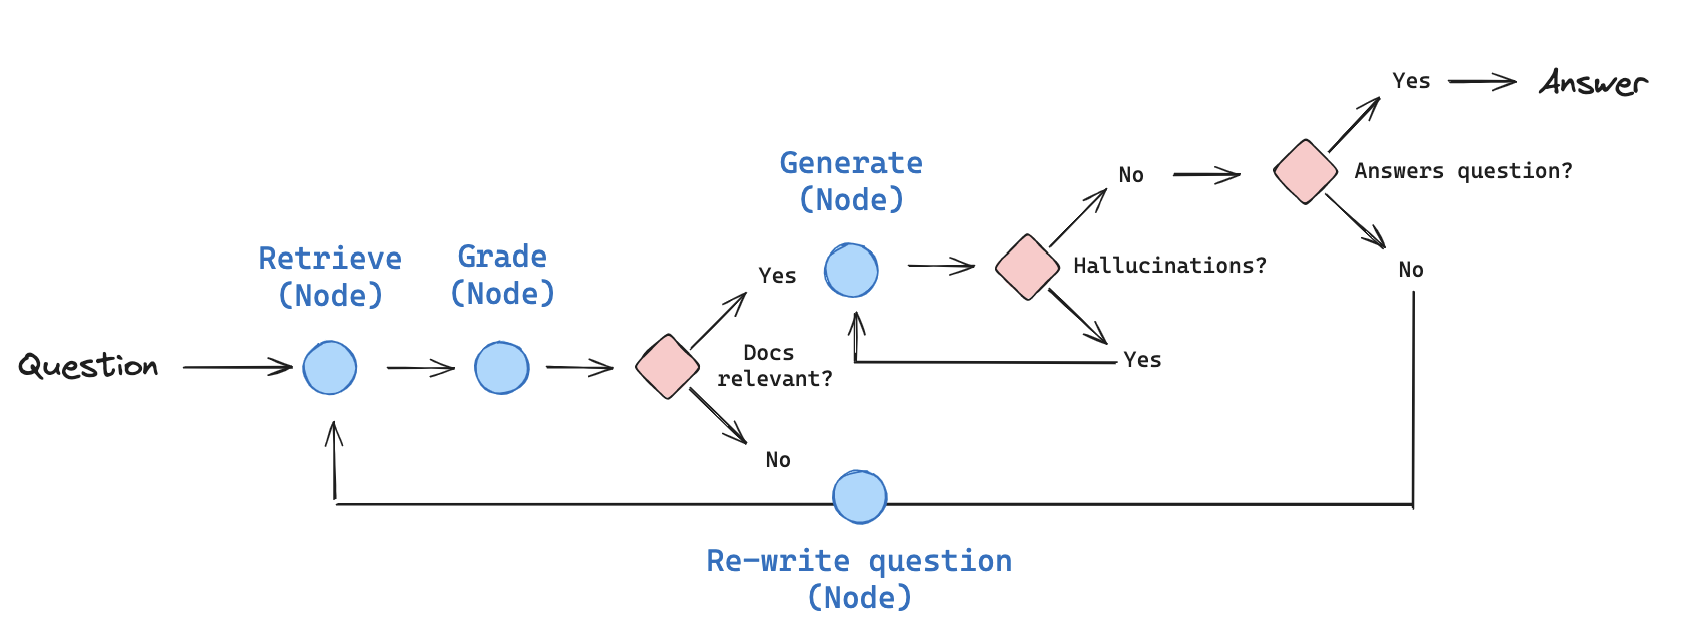

## Setup

First let's install our required packages and set our API keys

In [1]:
! pip install -U langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph

  Using cached tiktoken-0.8.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.6 kB)
  Using cached langchain_openai-0.2.3-py3-none-any.whl.metadata (2.6 kB)
  Using cached langchainhub-0.1.21-py3-none-any.whl.metadata (659 bytes)
  Using cached langchain-0.3.4-py3-none-any.whl.metadata (7.1 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached SQLAlchemy-2.0.36-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.7 kB)
  Using cached aiohttp-3.10.10-cp312-cp312-macosx_11_0_arm64.whl.metadata (7.6 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached langchain_core-0.3.12-py3-none-any.whl.metadata (6.3 kB)
  Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (61 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached regex-2024.9.11-cp312-cp312-macosx_11_0_arm64.whl.metadata (40 kB)
  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
  Using cached chroma_h

In [7]:
import getpass
import os

def _set_env(key_name: str, key_value: str):
    if key_name not in os.environ:
        os.environ[key_name] = key_value

# 'OPENAI_API_KEY'라는 환경 변수에 API 키 값을 설정
_set_env('OPENAI_API_KEY', 'sk-NwIPUQbv63OWc2zFhbb4cDqF-aSXCQ1aQ_0hb1AZWDT3BlbkFJHw4FoGFwZdQRtUd1UQm4eMsjlwT00v5KIPx7-BNtgA')


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Retriever
 
Let's index 3 blog posts.

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content='\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Auto

In [23]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist] # 내용 리스트화 

# 청크 사이즈를 250으로 하여 자르고 중복은 없게 한다. 
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# vectordb에 청크사이즈로 자른 것들을 임베딩하여 저장한다. 
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

## LLMs

In [24]:
### retriever가 잘 되고 있는지? -> 검색된 문서가 질문과 관련성이 있는지 


from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# gpt가 반환할 결과 형식을 정의 
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM과 함수 호출 
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
# gpt에 위 클래스를 연결하여 출력 형식을 정해줌 
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt => 엄격하지 않게 문서가 질문과 키워드 or 의미적으로 관련이 있는 경우 yes를 출력하도록  
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question) # 관련있는 문서를 4개 뽑음 
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [26]:
len(docs)

4

In [28]:
### 생성자 정의 

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt 가져옴 
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# # Post-processing
# def format_docs(docs):
#     return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/opt/anaconda3/envs/kmy_env/lib/python3.12/site-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Generative agents combine LLM with memory, planning, and reflection mechanisms to enable agents to behave based on past experiences and interact with other agents. The memory stream is a long-term memory module that records a comprehensive list of agents' experiences in natural language. LLM functions as the agent's brain in an autonomous agent system, complemented by key components like planning, subgoal decomposition, reflection, and refinement.


In [29]:
### Hallucination 이진분류 


# 답변이 주어진 문서에 기반하고 있는지 이진분류 
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    # 
    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# 지피티에게 해당 답변구조를 심어놓음 
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)


# 반환된 사실(문서)에 의해 답변이 잘 생성되고 있는지 확인
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [30]:
### Answer Grader


# 답변이 질문을 해결하면 yes, 그렇지 않음면 no로 평가 
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [6]:
### 입력 질의를 더 나은 버전으로 최적화하기 위해 질문을 다시 적는 시스템 -> 최적화된 벡터저장소 반환을 위해 

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt -> 입력 질문의 의미와 의도를 파악하도록 요청함. 
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

"What is the role of memory in an agent's functioning?"

# Graph 

Capture the flow in as a graph.

## Graph state

In [31]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str # 짊문 
    generation: str # 생성 
    documents: List[str] # 반환문서 

In [32]:
### Nodes


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question) # 반환된 문서 
    return {"documents": documents, "question": question} # 문서와 질문쌍 리턴


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question}) # 답변 생성 
    return {"documents": documents, "question": question, "generation": generation} # 문서, 질문, 답변쌍 생성 


def grade_documents(state): # 반환된 문서가 질문과 얼마나 관련성이 있는지 체킹 
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # 문서와 질문 간의 점수를 출력하여 서로 관련이 있다면 리스트에 해당 문서를 추가하여 반환함 
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state): # 질문을 특정한 형식이나 구조를 갖출 수 있도록 더 나은 질문으로 변경 
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


### Edges

# 2단계 노드 
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    # 필터링된 문서에 아무것도 없을 시 쿼리 변경 노드로 옮김 
    if not filtered_documents:

        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # 문서가 있다면 생성하기로 결심 
        print("---DECISION: GENERATE---")
        return "generate"


# 3단계 노드 
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # 할루시네이션 체킹 
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Build Graph

The just follows the flow we outlined in the figure above.

In [33]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
# 노드 설정 -> 반환, 문서 점수측정, 생성, 쿼리 변경 
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
# 1. 문서반환 -> 문서 점수 
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# 2. 문서 점수 -> 생성할 것인지 결정함수로 전이 
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query", # 2.1 쿼리 변경해야 할 경우 transform 으로 전이 
        "generate": "generate", # 2.2 그럴 필요 없다면 생성으로 전이하여 결과 생성 
    },
)
# 2.1.1 쿼리 변환에서 문서 반환으로 전이 2.1에서 전이된 노드
workflow.add_edge("transform_query", "retrieve") # 쿼리 변환 후 다시 문서 검색 
# 3. 생성에서 답변이 질문을 해결했는지(answer_grader) 분류하는 노드로 전이 
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate", # 3.1생성이 지원되지 않으면 다시 생성 후 
        "useful": END, # 4. 유용하면 종료 
        "not useful": "transform_query", # 3.2.1 유용하지 않으면 다시 쿼리 변환 
    },
)

# Compile
app = workflow.compile()

In [11]:
from pprint import pprint

# Run
inputs = {"question": "Explain how the different types of agent memory work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Short-term memory is used for in-context learning in agents, allowing them '
 'to learn quickly. Long-term memory enables agents to retain and recall vast '
 'amounts of information over extended periods. Agents can also utilize '
 'external tools like APIs to access additional information beyond what is '
 'stored in their memory.')


In [12]:
inputs = {"question": "Explain how chain of thought prompting works?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Chain of thought prompting works by repeatedly prompting the model to ask '
 'follow-up questions to construct the thought process iteratively. This '
 'method can be combined with queries to search for relevant entities and '
 'content to add back into the context. It extends the thought process by '
 'exploring multiple reasoning possibilities at each step, creating a tree '
 'structure of thoughts.')


LangSmith Traces - 
 
* https://smith.langchain.com/public/55d6180f-aab8-42bc-8799-dadce6247d9b/r

* https://smith.langchain.com/public/1c6bf654-61b2-4fc5-9889-054b020c78aa/r